In [1]:
# Restart the kernel
import os
current_dir ='../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *
from src.codes.base_classes import Base_class_fem_heat_conduction
from src.codes.reductor.rom_class import FEM_solver_rom_ecsw
from src.codes.algorithms.ecsw import ecsw_red


### class for data (geometry, material property, mesh)

In [3]:
n_ref = np.array([400, 100], dtype=int)
w = np.array([ 0.4, 0.1])
L = np.sum(w)

# Create arrays of zeros and ones
zeros_array = np.zeros((1, n_ref[0]))
ones_array = np.ones((1, n_ref[1]))

# Concatenate along the second axis (axis=1)
mat_layout = np.concatenate((zeros_array, ones_array), axis=1)
src_layout = np.concatenate((zeros_array, ones_array), axis=1)

In [4]:
fdict = {}

tune = 1

cond_list = []
cond_list.append(lambda T,mu: 1.05*mu*tune + 2150/(T-73.15))
cond_list.append(lambda T,mu: mu*tune*7.51 + 2.09e-2*T - 1.45e-5*T**2 + 7.67e-9*T**3)
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append(lambda T,mu: -2150/(T-73.15)**2 )
dcond_list.append(lambda T,mu: 2.09e-2 - 2*1.45e-5*T + 3*7.67e-9*T**2)
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 35000.0 + 0.*T)
qext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["qext"] = qext_list

In [5]:
bc = {}
bc['x_min']={'type':'refl','value':np.nan}
bc['x_max']={'type':'dirichlet','value':273.15+300.}   

In [6]:
print(mat_layout.flatten().shape[0])

500


In [7]:
class probdata:
    
    def __init__(self, bc, cond_layout, qext_layout, fdict, nref, L, mu, pb_dim=1):
        
        self.dim_ = pb_dim

        # refine the mesh and update material and source layouts
        self.cell2mat_layout = cond_layout.flatten()
        self.cell2src_layout = qext_layout.flatten()
        
        ## change this mapping if needed.
        self.fdict = fdict
        
        # mesh data cells
        self.ncells = [None] * pb_dim
        self.npts = [None] * pb_dim
        self.deltas = [None] * pb_dim
        self.xi=[]

        for i in range(pb_dim):

            self.ncells[i] = self.cell2mat_layout.shape[i]
            self.npts[i] = self.ncells[i]+1
            self.xi.append(np.linspace(0,L,self.npts[i]))
            self.deltas[i] = L/self.ncells[i]
    
        self.n_verts = self.npts[0]

        # Create nodal connectivity for the continuous Finite Element Method (cFEM)
        self.connectivity()
                
        # Store parameter value
        self.mu = mu
        
        # Store the dirichlet nodes if any
        handle_boundary_conditions(self, bc)
        
        # Determining the global equation numbers based on dirichlet nodes and storing in class
        get_glob_node_equation_id(self, self.dir_nodes)

        # Get global node numbers and equation IDs for the current element
        self.glob_node_eqnId = []
        self.glob_node_nonzero_eqnId = []
        self.local_node_nonzero_eqnId = []
        self.Le = []
        self.global_indices = []
        self.local_indices = []

        for i in range(self.n_cells):
            get_element_global_nodes_and_nonzero_eqnId(self, i, self.node_eqnId)   
    
    
    def connectivity(self):
        """
        Define nodal connectivity for each cell in the mesh.
        """

        # Initialize the connectivity array
        self.n_cells = self.ncells[0]
        
        self.gn = np.zeros((self.n_cells,2**self.dim_),dtype=int)
        
        # Loop over all cells to define their nodal connectivity
        
        for iel in range(self.n_cells):
            # For each cell, define the left and right nodes
            self.gn[iel, 0] = iel
            self.gn[iel, 1] = iel + 1
  

### Simulate FOS

In [8]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []
# 




 Snap 0 





initial residual = 8634851.262235392 

iter 0, NL residual=692826.395095454, delta=577.1178726852067
iter 1, NL residual=2947.5872178224154, delta=227.25713424877006
iter 2, NL residual=0.1351029848761672, delta=14.024113801572698
iter 3, NL residual=1.6018269078348443e-06, delta=0.040008049648693644
Convergence !!!



 Snap 1 



initial residual = 6743277.530184532 

iter 0, NL residual=721823.5959849502, delta=613.9447629267196
iter 1, NL residual=5018.56844199828, delta=294.7654855167417
iter 2, NL residual=0.4056998539690853, delta=25.777337345634752
iter 3, NL residual=1.368273744331443e-05, delta=0.1397558546856062
iter 4, NL residual=4.390077214634311e-08, delta=3.988038212489926e-06
Convergence !!!



 Snap 2 



initial residual = 9738269.2740245 

iter 0, NL residual=681611.0346377064, delta=560.8232186850987
iter 1, NL residual=2281.5266625470963, delta=198.7662862655317
iter 2, NL residual=0.08192715746369722, delta=10.232839800930304
iter 3, NL residual=9.408271169791163e

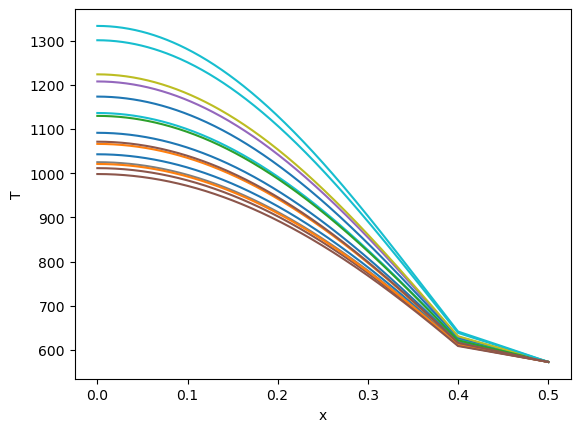

In [9]:
fig, ax = plt.subplots()

for i in range(N_snap):
    print(f"\n\n\n Snap {i} \n\n\n")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param, pb_dim=1)
        FOS = Base_class_fem_heat_conduction(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 273.15
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    plot1D(d.xi[0], NL_solution_p, ax=ax)

plt.show()


In [10]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 501)

### ECSW Hyper-reduction


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

In [11]:
n_sel = 4
U, S, Vt = np.linalg.svd(np.transpose(NLS), full_matrices=False)
V_sel = U[:, :n_sel]
P_sel = V_sel[mask,:]@np.transpose(V_sel[mask,:])

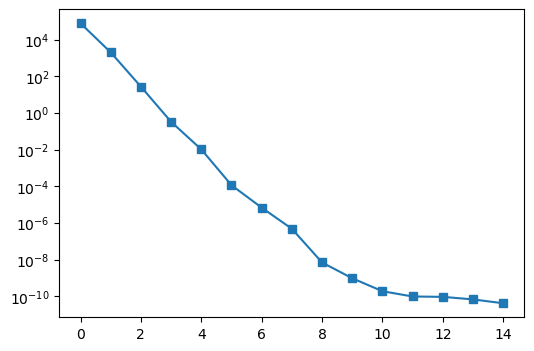

In [12]:
plt.figure(figsize = (6,4))
plt.semilogy(S,'s-')
plt.show()

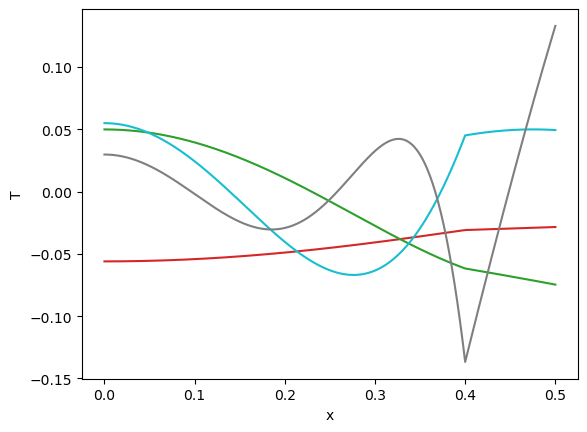

In [13]:
fig, ax = plt.subplots()

for i in range(n_sel):
    plot1D(d.xi[0],V_sel[:,i],ax=ax)

plt.show()


#### ECSW

In [14]:
tic_h_setup_b = time.time()
tol = 1e-8
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap, mask,NL_solutions,tol=tol)
toc_h_setup_b = time.time()

d:\D\ONEDRIVE\OneDrive - Texas A&M University\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\Hyperreduction_tamids\pyHyperRom\src\codes\algorithms\nnls_scipy.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=2.17845e-17): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
d:\D\ONEDRIVE\OneDrive - Texas A&M University\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\Hyperreduction_tamids\pyHyperRom\src\codes\algorithms\nnls_scipy.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=2.42592e-17): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
d:\D\ONEDRIVE\OneDrive - Texas A&M University\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\Hyperreduction_tamids\pyHyperRom\src\codes\algorithms\nnls_scipy.py:135: LinAlgWarning: Ill-conditioned matrix (rcond=3.74524e-18): result may not be accurate.
  s[P] = solve(AtA[P_ind[:, None], P_ind[None, :]], Atb[P],
d:\D\ONEDRIVE\OneDrive - Texas A&M University\TAMU_MATERIALS\POS

In [15]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 0.00020422539027224206


In [16]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

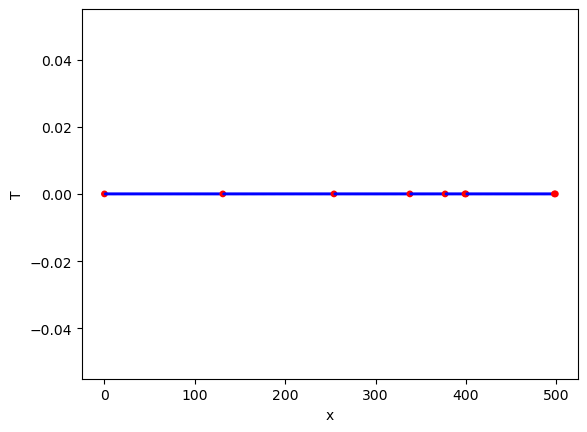

In [17]:
plot1D(np.arange(d.ncells[0]), np.zeros_like(xi), scattr=True, clr=colors, sz=sizes)

In [18]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 1.8%



### ROM Simulation

In [19]:
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [20]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param_rom, pb_dim=1)
FOS_test = Base_class_fem_heat_conduction(d_test,quad_deg)
ROM = FEM_solver_rom_ecsw(d_test, quad_deg)

In [21]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 273.15
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [22]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

initial residual = 5121928.621671218 

iter 0, NL residual=767085.6491309204, delta=662.4431892840048
iter 1, NL residual=9170.357065593953, delta=385.5108800528815
iter 2, NL residual=1.7012921798759322, delta=47.761081721791776
iter 3, NL residual=0.00014300922331612415, delta=0.4939698922092143
iter 4, NL residual=3.747633245446698e-08, delta=5.043698276272934e-05
Convergence !!!


In [23]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,np.ones_like(xi),V_sel)
toc_rom_woh = time.time()

initial residual = 726396.4075675734 



c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


iter 0, NL residual=1423.487997349153, delta=-175.6905063728559
iter 1, NL residual=92.0579473756898, delta=2371.487834244348
iter 2, NL residual=1.7164119517713305, delta=411.60553073378054
iter 3, NL residual=0.0005012638836095363, delta=6.341703367968802
iter 4, NL residual=3.1039313638184144e-08, delta=0.0012342310955993693
Convergence !!!


In [24]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced = ROM.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

initial residual = 726423.806728154 

iter 0, NL residual=1304.5782120897227, delta=-178.14205023153866
iter 1, NL residual=92.87570320794195, delta=2373.1603818805893
iter 2, NL residual=1.709539801558782, delta=420.39732271951146
iter 3, NL residual=0.0005610395273249217, delta=6.675954888676754
iter 4, NL residual=4.4160092731653186e-08, delta=0.0013700287154527343
Convergence !!!


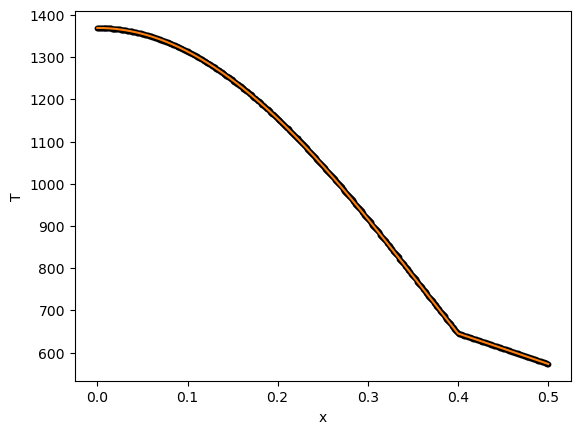

RMS_error is 0.00014737488020904904 %


In [25]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)

fig, ax = plt.subplots()

plot1D(d_test.xi[0], sol_red, ax=ax)
plot1D(d_test.xi[0], NL_solution_p_fos_test, ax=ax, scattr=True, clr='k', sz=10)

plt.show()

print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

In [26]:

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")



ROM Error without hyperreduction is 0.00014697887533645648 %



#### Speedups

In [27]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [28]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:0.9432521292461951
speedup with hyperreduction:38.08434759869847
